In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [2]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [3]:
medium = td.Medium(permittivity=29)
run = False

In [4]:
a=1.5873

In [5]:
lambdas =  a/np.array([0.15,0.48])
lambdas

array([10.582   ,  3.306875])

In [6]:
3e10/(lambdas)  * 1e-9 #frequencies of experiment 

array([2.83500284, 9.07200907])

In [7]:
folder_path=rf"H:\phd stuff\tidy3d\structures\2D SHU"
sample = 1
project_name = fr"20250625 2D eps 29 4-9GHz Different Dipole Position True Units"
empty=False
runtime_ps = 30e-12
min_steps_per_lambda = 25
id0 = ""
ref_slices = []
slab_size_x = 55

chi_0.20_N_10000_posics
chi_0.30_N_10000_posics
chi_0.31_N_10000_posics
chi_0.32_N_10000_posics
chi_0.33_N_10000_posics
chi_0.34_N_10000_posics
chi_0.35_N_10000_posics
chi_0.36_N_10000_posics
chi_0.37_N_10000_posics
Configured successfully.
chi_0.37_N_10000_posics_emmiter_-5.5000 - Sample_0


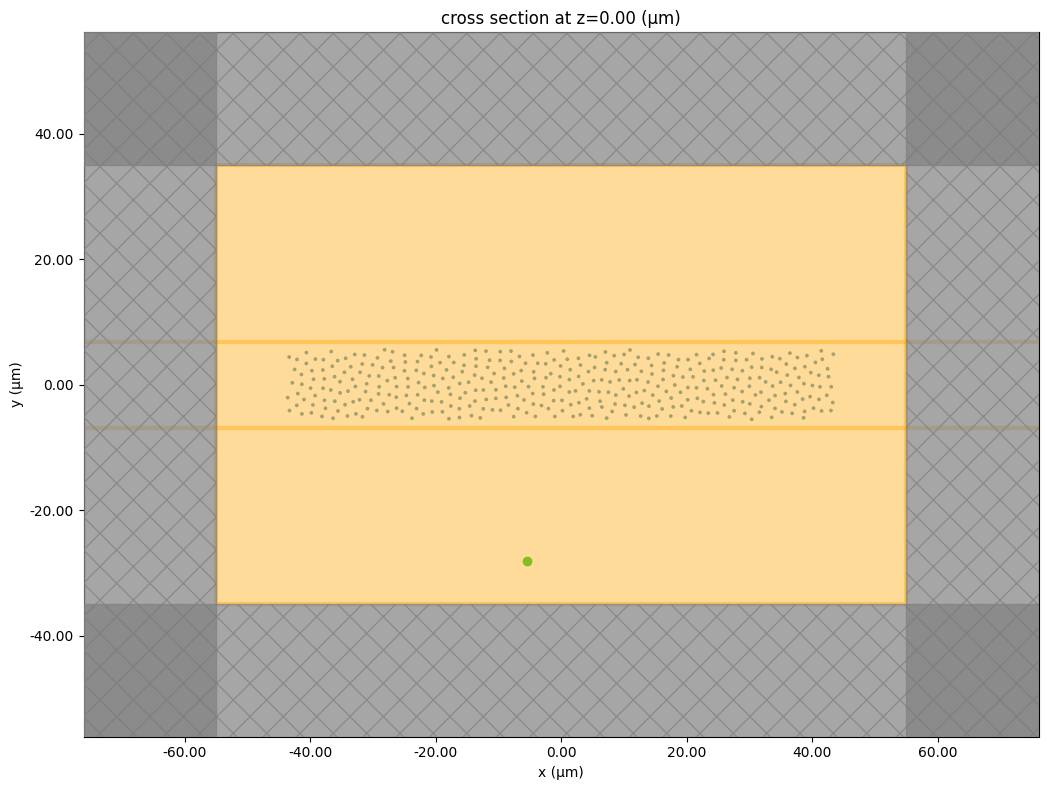

TypeError: Program ends here

In [8]:
count = 0
for l,file in enumerate(natsorted(os.listdir(folder_path))):
    print(Path(file).stem)
    if Path(file).stem not in ["chi_0.37_N_10000_posics"]:
        continue
    data = []
    centers = []

    with open(os.path.join(folder_path, file),"r") as f: 
        lines = f.read().splitlines() 
        i=0
        index = 1
        num_samples = int(lines[index].split()[0])

        while num_samples>0 and i < sample+1:
            try:
                num_samples = int(lines[index].split()[0])
                info = lines[index]
                old_index = index
                index += num_samples+1
                li = (lines[old_index+1:index])
                centers = np.array([list(map(float, item.split())) for item in li])
                data += [{
                    "centers":centers,
                    "Lx":float(lines[old_index].split()[1]),
                    "Ly":float(lines[old_index].split()[2]),
                    "points":float(lines[old_index].split()[0]),
                }]
                i+=1
            except:
                num_samples = 0
    

    for k,item in enumerate(data):
        if k >= sample:
            continue
        

        structure_1 = AM.loadAndRunStructure(key = tidy3dAPI
                    ,direction="z", lambda_range=lambdas,
                    box_size= data[k]['Lx'],runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                   scaling=1,shuoff_condtion=1e-20, verbose=True,
                   monitors=["flux"],
                   freqs=500, 
                   source="planewave", 
                   width=0.4, ref_only=True
                   )


        sim = structure_1.sim



        boundaries= td.BoundarySpec(
                x=td.Boundary(plus=td.Absorber(num_layers=160),minus=td.Absorber(num_layers=160)),
                y=td.Boundary(plus=td.Absorber(num_layers=160),minus=td.Absorber(num_layers=160)),
                z=td.Boundary.periodic(),
            )
        sim = sim.copy(update={'boundary_spec':boundaries})
        sim = sim.copy(update={'sources':[]})
        sim = sim.copy(update={'monitors':[]})


        slices= [0.07]
        for l,slicing in enumerate(slices):
         x_positions =  np.arange(-5.5, 6.5, 1)
         for n,x_position in enumerate(x_positions):
            run_name = f"{Path(file).stem}_emmiter_{x_position:.4f} - Sample_{k}"
            print(run_name)
            count = count+1
            Lx,Ly=110,70
            sim = sim.copy(update={'size':[Lx,Ly,0]})


            sources = []
            y_position = -100/2*a*slicing-22.5
            
            sources.append(
                    td.PointDipole(
                        center=(x_position, y_position, 0), 
                        source_time=td.GaussianPulse(freq0=structure_1.freq0, fwidth=structure_1.freqw),
                        polarization='Ez'
                    )
                )


            sim = sim.copy(update={'sources':sources})
            

            

            time_monitorFieldOut = td.FieldTimeMonitor(
                        center = (0,0,0),
                        size = (Lx,Ly,0),
                            start=0,
                            stop=structure_1.t_stop,
                            interval=50,
                            fields=["Ex", "Ey", "Ez"],
                            name="time_monitorFieldOut",

                        )


            freq_monitorFieldOut = td.FieldMonitor(
                        center = (0,0,0),
                        size = (Lx, Ly,0),
                           freqs =structure_1.monitor_freqs,
                            fields=["Ex", "Ey", "Ez"],
                            name="freq_monitorFieldOut",

                        )

           
            monitor_1 = td.FluxMonitor(
                    center = (
                                    0,-((Lx*slicing)/2+3),0
                                    ),
                    size = (
                       td.inf,0,td.inf
                        ),
                    freqs = structure_1.monitor_freqs,
                    name='flux2' )

            monitor_2 = td.FluxMonitor(
                    center = (
                                    0,(Lx*slicing)/2+3,0
                                    ),
                    size = (
                       td.inf,0,td.inf
                        ),
                    freqs = structure_1.monitor_freqs,
                    name='flux1' 
                )

            sim = sim.copy(update={'monitors':[freq_monitorFieldOut,monitor_1,monitor_2]})


            cyl_group = []
            for x,y in data[k]['centers']:
                x,y = x*a,y*a
                if np.abs(y)<=(100/2*a*slicing) and np.abs(x)<=(slab_size_x/2 * a):
                    cyl_group.append(td.Cylinder(center=[x, y, 0], radius=0.189*a, length=td.inf))

            cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)


            if empty:
                sim = sim.copy(update={'structures':[],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})
            else:
                sim = sim.copy(update={'structures':[cylinders],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})


            fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
            sim.plot(z=0, ax=ax)
            plt.show()
            sim_name = run_name
            if run:
                folder_run = Path(file).stem + fr"_L={Ly*slicing:.2g}"
                file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/{sim_name}.txt"
                
                if os.path.exists(file_path):
                    print("Exist!!")
                else:
                    try:
                        id0 = ref_slices[n]
                    except:
                        id0 =web.upload(sim.copy(update={'structures':[]}), folder_name=project_name,task_name=fr"{sim_name}_ref", verbose=True)
                        web.start(task_id = id0)
                        ref_slices += [id0]


                    id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
                    web.start(task_id = id)
                    ids = id0+ '\n' + id
                    # Check if the folder exists
                    if not os.path.exists( fr"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/"):
                        os.makedirs(fr"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/")
                        print(fr"Folder 'H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/' created successfully.")

                    # Open file in write mode
                    with open(file_path, "w") as f:
                        # Write the string to the file
                        f.write(ids)
                
            else:
                # id =web.upload(sim,task_name=sim_name, verbose=True)
                # print(web.estimate_cost(id))
                raise TypeError("Program ends here")



In [9]:
-100/2*a*slicing

-5.55555